In [3]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import processStocks as sdp

# Load newest stock data from Yahoo Finance

In [4]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('ASTC','yahoo',start,end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-12-21,120.0,125.0,120.0,120.0,120.0,70200.0
1995-12-22,120.0,122.5,120.0,120.0,120.0,41600.0
1995-12-26,120.0,122.5,120.0,120.0,120.0,1500.0
1995-12-27,122.5,122.5,120.0,120.0,120.0,6600.0
1995-12-28,120.0,122.5,120.0,120.0,120.0,22500.0


# Normalise and Prepozess the data like a boss^12

In [11]:
#normalise data
data_n = sdp.normalize_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
1995-12-21,0.728648,3.0,0.006483,1.0,1.000000,1.041667,1.0,0.000000,0.0,0.000000,0.000000,0.0
1995-12-22,0.728649,4.0,0.003842,1.0,1.000000,1.020833,1.0,-0.996158,0.0,0.000000,0.020833,0.0
1995-12-26,0.728653,1.0,0.000139,1.0,1.000000,1.020833,1.0,-0.999861,0.0,0.000000,0.020833,0.0
1995-12-27,0.728654,2.0,0.000609,1.0,1.020833,1.020833,1.0,-0.999391,0.0,0.020833,0.020833,0.0
1995-12-28,0.728655,3.0,0.002078,1.0,1.000000,1.020833,1.0,-0.997922,0.0,0.000000,0.020833,0.0


# 1,2,3 Plot Line!

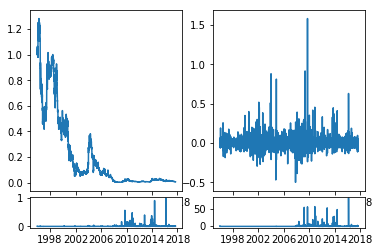

In [12]:
sdp.stock_plot(data_n)

# Pickup the Data

In [13]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [14]:
x_train

array([[  7.28648000e-01,   3.00000000e+00,   6.48283250e-03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.28649000e-01,   4.00000000e+00,   3.84167852e-03, ...,
          0.00000000e+00,   2.08333333e-02,   0.00000000e+00],
       [  7.28653000e-01,   1.00000000e+00,   1.38522062e-04, ...,
          0.00000000e+00,   2.08333333e-02,   0.00000000e+00],
       ..., 
       [  7.35849000e-01,   1.00000000e+00,   2.64115398e-03, ...,
          0.00000000e+00,   1.76211454e-02,  -6.16740088e-02],
       [  7.35850000e-01,   2.00000000e+00,   1.03429806e-03, ...,
          1.75438596e-02,   1.75438596e-02,  -1.31578947e-02],
       [  7.35851000e-01,   3.00000000e+00,   2.65038879e-03, ...,
          2.22222222e-02,   5.33333333e-02,   1.33333333e-02]])

# unroll it

In [15]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4914, 50, 12)
y_train (4914,)
x_test (450, 50, 12)
y_test (450,)


In [32]:
x_train[1, 5]

array([ 0.72866   ,  1.        ,  0.00160686,  1.01041667,  1.        ,
        1.04166667,  1.        , -0.99842594, -0.01020408, -0.02040816,
        0.02040816, -0.02040816])

# Go! (with Python 3.5, Keras 1.2.2 and Tensorflow 1.0, better on AWS)

In [34]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [35]:
x_train.shape

(4914, 50, 12)

In [36]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[-1]),
    units =50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.013993978500366211


In [41]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, None, 12),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 0,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 50,
   'unroll': False,
   '

In [37]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=50,
    validation_split=0.05)

Train on 4665 samples, validate on 246 samples
Epoch 1/50
4665/4665 [==============================] - 15s - loss: 0.1265 - val_loss: 0.0030
Epoch 2/50
4665/4665 [==============================] - 12s - loss: 0.0082 - val_loss: 0.0012
Epoch 3/50
4665/4665 [==============================] - 12s - loss: 0.0072 - val_loss: 0.0012
Epoch 4/50
4665/4665 [==============================] - 12s - loss: 0.0069 - val_loss: 0.0011
Epoch 5/50
4665/4665 [==============================] - 12s - loss: 0.0069 - val_loss: 0.0012
Epoch 6/50
4665/4665 [==============================] - 12s - loss: 0.0065 - val_loss: 0.0012
Epoch 7/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0011
Epoch 8/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0012
Epoch 9/50
4665/4665 [==============================] - 12s - loss: 0.0064 - val_loss: 0.0012
Epoch 10/50
4665/4665 [==============================] - 12s - loss: 0.0066 - val_loss: 0.0012
Epoch 11/50


In [55]:
model.save('./lstm_model.h5')

yo


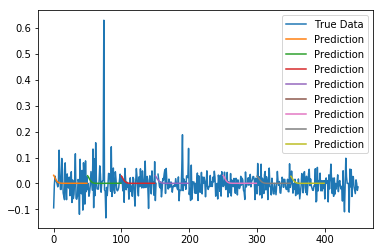

In [50]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [58]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequence_full(model, x_test, 30)

yo


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

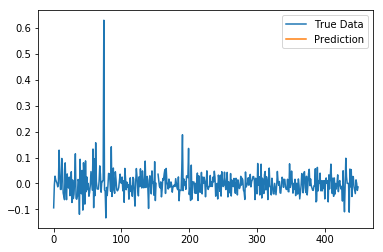

In [59]:
lstm.plot_results_multiple(predictions, y_test, 1)